# Validate synthetic data via Train-Synthetic-Test-Real

In this tutorial, we demonstrate the process of evaluating the quality of synthetic data based on its utility for a downstream Machine Learning (ML) task. The method is commonly referred to as the Train-Synthetic-Test-Real (TSTR) evaluation [[1](#refs)]. The TSTR evaluation serves as a robust measure of synthetic data quality because ML models rely on the accurate representation of deeper underlying patterns to perform effectively on previously unseen data. As a result, this approach offers a more reliable assessment than simply evaluating higher-level statistics.

See image below for the general setup of TSTR.

<img src='./TSTR.png' width="600px"/>

Thus, we take actual (=real) data, and split it into a holdout and a training dataset. Next, we create a synthetic dataset only based on the training data. Then we train a Machine Learning (ML) model, and do so once using the synthetic data and once using the actual training data. And finally we evaluate the performance of each of those two models on top of the actual holdout data, that was kept aside all along. By comparing the performance of these two models, we can assess how much utility has been retained by the synthesization method with respect to a specific ML task.

Note, that one needs to use a true holdout for the evaluation to properly measure out-of-sample performance, as this is the relevant metric for real-world use cases. If one uses the same training data that has been used for the synthesis, one would "leak" information from training into evaluation. This becomes particularly an issue for synthesizers that are prone to overfitting, and simply memorize the samples that it has been exposed to. If one, on the other hand, were to use synthetic data for the evaluation, one would not get meaningful results either, as the synthetic data might not be representative of the real data. E.g., consider the degenerate case of a synthesizer that only produces the same record over and over again. Any model trained on that data, would yield perfect results when evaluated on it again, whereas it will be of no use when applied to real data.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using a cleaned up version of the UCI Adult Income [[2](#refs)] dataset, that itself stems from the 1994 American Community Survey [[3](#refs)] by the US census bureau. The dataset consists of 48,842 records, 14 mixed-type features and has 1 target variable, that indicates whether a respondent had or had not reported a high level of annual income. This dataset is being selected, as it's one of the go-to datasets commonly used to showcase machine learning models in action.

1. Download `census-training.csv` by clicking [here](https://github.com/mostly-ai/mostly-tutorials/raw/dev/train-synthetic-test-real/census-training.csv) and pressing Ctrl+S to save the file locally. This is an 80% sample of the full dataset. The remaining 20% sample can be fetched from [here](https://github.com/mostly-ai/mostly-tutorials/raw/dev/train-synthetic-test-real/census-holdout.csv).

2. Synthesize `census-training.csv` via [MOSTLY AI](https://mostly.ai/). You can leave all settings at their default, and just proceed to launch job.

<img src='./screen1.png' width="400px"/> <img src='./screen2.png' width="400px"/><br /><img src='./screen3.png' width="400px"/> <img src='./screen4.png' width="400px"/>

3. Once the job has finished, download the generated synthetic data as CSV file to your computer.

4. Upload the generated synthetic data to this Notebook via executing the next cell.


In [1]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    print("running in COLAB mode")
    repo = 'https://github.com/mostly-ai/mostly-tutorials/raw/dev/train-synthetic-test-real'
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
except:
    print("running in LOCAL mode")
    repo = '.'
    print("adapt `syn_file_path` to point to your generated synthetic data file")
    syn_file_path = './census-synthetic.csv'
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
    
# fetch training and holdout data
train = pd.read_csv(f'{repo}/census-training.csv')
print(f'fetched training data with {train.shape[0]:,} records and {train.shape[1]} attributes')
holdout = pd.read_csv(f'{repo}/census-holdout.csv')
print(f'fetched holdout data with {holdout.shape[0]:,} records and {holdout.shape[1]} attributes')

running in LOCAL mode
adapt `syn_file_path` to point to your generated synthetic data file
read synthetic data with 39,074 records and 15 attributes
fetched training data with 39,074 records and 15 attributes
fetched holdout data with 9,768 records and 15 attributes


## Explore Synthetic Data

Show 10 randomly sampled synthetic records. Note, that you can execute the following cell multiple times, to see different samples.

In [2]:
syn.sample(n=10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
23665,19,?,229006,Some-college,10,Never-married,?,Own-child,White,Male,0,0,25,United-States,<=50K
31279,19,Private,205517,12th,8,Never-married,Other-service,Not-in-family,White,Female,0,0,20,United-States,<=50K
5190,38,State-gov,107442,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,Other,Male,0,0,60,United-States,<=50K
33411,30,State-gov,294976,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K
36726,37,State-gov,85915,Masters,14,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,50,United-States,>50K
18808,48,Private,90794,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States,>50K
34021,53,Local-gov,136891,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
31713,23,Private,96873,Masters,14,Never-married,Craft-repair,Not-in-family,White,Male,0,0,39,United-States,<=50K
37214,32,Private,183630,Some-college,10,Separated,Exec-managerial,Unmarried,White,Female,0,0,58,United-States,<=50K
18427,20,Private,310179,Some-college,10,Never-married,Craft-repair,Own-child,White,Male,0,0,35,United-States,<=50K


Show 5 randomly sampled Female Professors of age 30 or younger.

In [3]:
syn.loc[(syn["sex"]=="Female") & (syn["education"]=="Prof-school") & (syn["age"]<=30)].sample(n=5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
21791,28,Self-emp-inc,212652,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,25,United-States,<=50K
3141,27,Private,487652,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,<=50K
8747,29,Private,206948,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,45,United-States,<=50K
23672,30,Private,173532,Prof-school,15,Married-civ-spouse,Sales,Wife,White,Female,0,0,45,United-States,>50K
19369,29,Private,102373,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,28,Canada,<=50K


Count low-income (<=50K) and high-income (>50K) records within the synhetic sample.

In [4]:
syn['income'].value_counts()

<=50K    29485
>50K      9589
Name: income, dtype: int64

Count low-income and high-income records among the group of non-US citizen, that have been divorced.

In [5]:
syn.loc[(syn["native_country"]!="United-States") & (syn["marital_status"]=="Divorced")]['income'].value_counts()

<=50K    360
>50K      38
Name: income, dtype: int64

## Compare ML Performance

Let's now train a state-of-the-art **LightGBM** classifier on top of the synthetic data, to then check how well it can predict whether an actual person reported an annual income of more than $50K or not. We will then compare the predictive accuracy to a model, that has been trained on the actual data, and see whether we were able to acchieve a similar performance purely based on the synthetic data.

In [6]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

target_col = 'income'
target_val = '>50K'

def prepare_xy(df):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_hol, probs)
    acc = accuracy_score(y_hol, preds)
    probs_df = pd.concat([
        pd.Series(probs, name='probability').reset_index(drop=True),
        pd.Series(y_hol, name='actuals').reset_index(drop=True)
    ], axis=1)
    fig = sns.displot(data=probs_df, x='probability', hue='actuals', bins=20, palette=['#008CFB', '#FF004F'])
    fig = plt.title(f"Accuracy: {acc:.1%}, AUC: {auc:.1%}", fontsize=20)
    plt.show()
    return auc

import warnings
warnings.filterwarnings('ignore')

### Train a Model on Synthetic Data - Test on Real Data

We train the LightGBM on synthetic data, and then evaluate its performance on holdout data. We report two performance metrics: 
1. **Accuracy**: This is the probability to correctly predict the `income` class of a randomly selected record.
2. **AUC** (Area-Under-Curve): This is the probability to correctly predict the `income` class, if two records, one of high-income and one of low-income are given.

Whereas the Accuracy informs about the overall ability to get the class attribution correct, the AUC specifically informs about the ability to properly rank records, with respect to their probability of being within the target class or not. In both cases, the higher the metric, the better the predictive accuracy of the model.

The displayed chart shows the distribution of scores, that the model assigned to each of the holdout records. A score close to 0 means that model is very confident, that the record is of low income. A score close to 1 means that the model is very confident that it's a high income record. These scores are further split by their actual outcome, i.e. whether they are or are not actually high income. This allows to visually inspect the model's confidence in assigning the right scores.

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's auc: 0.910036


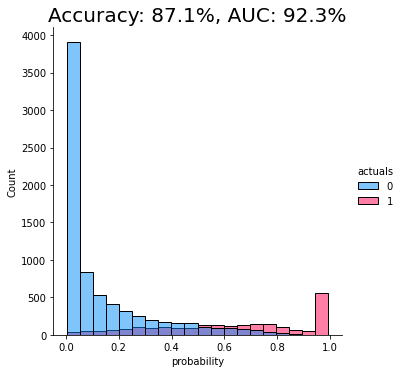

In [7]:
# prepare synthetic data, and split into features `X` and target `y`
X_syn, y_syn = prepare_xy(syn)
# train ML model on synthetic data with early stopping to prevent overfitting
model_syn = train_model(X_syn, y_syn)
# evaluate trained model on original holdout data
auc_syn = evaluate_model(model_syn, holdout)

### Train a Model on Real Data - Test on Real Data

Let's now compare these results acchieved on synthetic data, with a model trained on real data. For a very good synthesizer, we expect to see a predictive performance of the two models being close to each other.

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.929897


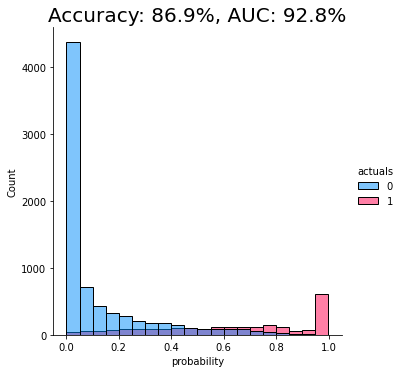

In [8]:
# prepare original training data, and split into features `X` and target `y`
X_trn, y_trn = prepare_xy(train)
# train ML model on original training data with early stopping to prevent overfitting
model_trn = train_model(X_trn, y_trn)
# evaluate trained model on original holdout data
auc_trn = evaluate_model(model_trn, holdout)

## Conclusion

For the given dataset, and the given synthesizer, we can observe a near on-par performance of the synthetic data with respect to the given downstream ML task. This means, that one can train the model purely on synthetic data, and yield just as good results as if it were trained on real data, but without ever putting the privacy of any of the contained individuals at any risk.

## Further exercises

In addition to walking through the above instructions, we suggest..
* to run Train-Synthetic-Test-Real 
  * using a different dataset, eg. the UCI bank-marketing dataset [[4](#refs)]
  * using a different downstream ML model, eg. a RandomForest model [[5](#refs)]
  * using a different synthesizer, eg. SynthCity, SDV, etc.
* to check the impact of synthetic upsampling
  * generate 10x or 100x the original data records, and see whether it improves ML accuracy

## References<a class="anchor" name="refs"></a>

1. https://arxiv.org/pdf/1706.02633.pdf §3.1.2
1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://www.census.gov/programs-surveys/acs
1. https://archive.ics.uci.edu/ml/datasets/bank+marketing
1. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Extras: Data Preparation

The following code snippet can be used to split a DataFrame into a training and a holdout dataset. This is useful, if you run experiments on your own data.

In [9]:
from sklearn.model_selection import train_test_split

df = pd.DataFrame({'x': range(10), 'y': range(10, 20)})
df_trn, df_hol = train_test_split(df, test_size=0.2, random_state=1)
display(df_trn)
display(df_hol)

,x,y
6,6,16
4,4,14
0,0,10
3,3,13
1,1,11
7,7,17
8,8,18
5,5,15


,x,y
2,2,12
9,9,19
